In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
header=['target','ids','date','flag','user','text']
path='/content/drive/MyDrive/Twitter Sentiment Analysis Data/training.1600000.processed.noemoticon.csv'
df=pd.read_csv(path,encoding='Latin-1',names=header)

In [ ]:
df.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [ ]:
# Checking the  target:0 Negative Sentiment, target: 4 is positive sentiment.
df['target'].value_counts(normalize=True)

0    0.5
4    0.5
Name: target, dtype: float64

In [ ]:
# Check for Null values
df.isnull().sum()

target    0
ids       0
date      0
flag      0
user      0
text      0
dtype: int64

## Data Preparation
   1. Splitting the data into train(70%), validation(10%), and test (20%) set.

In [ ]:
df['target']=[1 if i==4 else 0 for i in df['target']]

In [ ]:
df['target'].value_counts(normalize=True)

0    0.5
1    0.5
Name: target, dtype: float64

In [ ]:
def train_val_test_split(df, train_frac=.6, val_frac=.2, seed=None):
    """ This function will be used to convert the dataset into train,test, and split.
    """
    np.random.seed(seed)
    shuffle_idx = np.random.permutation(df.index) # To shuffle the data
    n = len(df)
    train = int(train_frac* n)
    val = int(val_frac * n) + train
    train_df = df.iloc[shuffle_idx[:train]]
    valid_df = df.iloc[shuffle_idx[train:val]]
    test_df = df.iloc[shuffle_idx[val:]]
    return train_df, valid_df, test_df

In [ ]:
# Divide the data into Train(70%), Validation(10%) and Test Set(20%)
train,val,test=train_val_test_split(df=df,train_frac=0.7,val_frac=0.1,seed=25)

### Preprocess the text data 
    1. Removing the regular expression,URLs,Twitter handles,stopwords, numerics, and alphanumeric
    2.Tokenizing the text
    3.Lowercase
    4. Lemmatization 

In [ ]:
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer  # for lemmatization
import time
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
wordnet=WordNetLemmatizer()
stop_words=stopwords.words('english')+['com','http','https']

In [ ]:
def text_preprocess(text):
    x=re.sub(r'http\S+','',text)  # Removing the URLs
    x=re.sub(r'@\S+','',x)        # Removing the twitter handle
    x=re.sub('[^a-zA-Z]',' ',x)   # only keeping the text
    x=x.lower().split()  # Tokenizing the text by sentence
    x=[wordnet.lemmatize(word) for word in x if word not in stop_words and len(word)>1] # Lemmatize the wordnet
    #x=' '.join(x)
    return x

In [ ]:
# Preprocess the text and converting the 
x_train=list(train['text'].values)
y_train=list(train['target'].values)
for i in range(0,len(x_train)):
    x_train[i]=text_preprocess(x_train[i])

In [ ]:
# Preprocess the validation set
x_val=list(val['text'].values)
y_val=list(val['target'].values)
for i in range(0,len(x_val)):
    x_val[i]=text_preprocess(x_val[i])

In [ ]:
# Preprocess the test set 
x_test=list(test['text'].values)
y_test=list(test['target'].values)
for i in range(0,len(x_test)):
    x_test[i]=text_preprocess(x_test[i])

In [ ]:
train['target'].value_counts(normalize=True)

0    0.500346
1    0.499654
Name: target, dtype: float64

In [ ]:
test['target'].value_counts(normalize=True)

1    0.500478
0    0.499522
Name: target, dtype: float64

## Word2Vec Model: CBOW model 

In [ ]:
from gensim.models import Word2Vec

In [ ]:
model = Word2Vec(sentences=x_train, vector_size=15, window=2, min_count=1, workers=4)

In [ ]:
model.wv.most_similar('haha',topn=5)

[('hahaha', 0.9583282470703125),
 ('hahah', 0.9475937485694885),
 ('hah', 0.9427162408828735),
 ('lol', 0.9400179982185364),
 ('yeah', 0.934079647064209)]

In [ ]:
model.wv.most_similar('egg',topn=5)

[('bread', 0.972442090511322),
 ('tuna', 0.9662915468215942),
 ('bacon', 0.9632316827774048),
 ('oven', 0.9630887508392334),
 ('oreo', 0.962459146976471)]

In [ ]:
model.save('word2vec_2swd_vec_size_15.model')

In [ ]:
def transform(w2v_model,data):
    n=len(model.wv[0])
    m=len(data)
    vec=[]
    for i in data:
        count=0
        temp=np.zeros(n)
        for j in i:
            if j in w2v_model.wv:
                temp+=w2v_model.wv[j]
                count+=1
            else:
                continue
        if count!=0:
            vec.append(temp/count)  
        else:
            vec.append(temp)
    return np.array(vec)

In [ ]:
# Converting the text data into Numerical Features.
x_train_vec=transform(model,x_train)
x_val_vec=transform(model,x_val)
x_test_vec=transform(model,x_test)


# Machine Learning training Models

In [ ]:
# Important Libraries for Model Evaluation
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report,roc_curve,roc_auc_score
import seaborn as sns

### 1. Decision Tree Classifier

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
def train_decision_tree(x,y,**params):
  dt=DecisionTreeClassifier(random_state=0)
  dt.set_params(**params)
  dt.fit(x,y)
  return dt

In [ ]:
# Train the model with default parameters
dt=DecisionTreeClassifier()
dt.fit(x_train_vec,y_train)

DecisionTreeClassifier()

In [ ]:
dt.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

In [ ]:
# Training score
print('Training Accuracy:',dt.score(x_train_vec,y_train))
print('Validation Accuracy:',dt.score(x_val_vec,y_val))

Training Accuracy: 0.9878625
Validation Accuracy: 0.634075


In [ ]:
# Classification Report  on training set
y_pred=dt.predict(x_train_vec)
print(classification_report(y_train,y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99    560387
           1       0.99      0.99      0.99    559613

    accuracy                           0.99   1120000
   macro avg       0.99      0.99      0.99   1120000
weighted avg       0.99      0.99      0.99   1120000



In [ ]:
# ROC AUC Score
y_score=dt.predict_proba(x_train_vec)[:,1]
#define metrics
fpr, tpr, _ =roc_curve(y_train,  y_score)
auc = roc_auc_score(y_train, y_score)
print('ROC-AUC on training set:',auc)

ROC-AUC on training set: 0.9996432405407158


In [ ]:
# Classification report on validation set
y_pred=dt.predict(x_val_vec)
print(classification_report(y_val,y_pred))

              precision    recall  f1-score   support

           0       0.63      0.64      0.64     79766
           1       0.64      0.63      0.64     80234

    accuracy                           0.64    160000
   macro avg       0.64      0.64      0.64    160000
weighted avg       0.64      0.64      0.64    160000



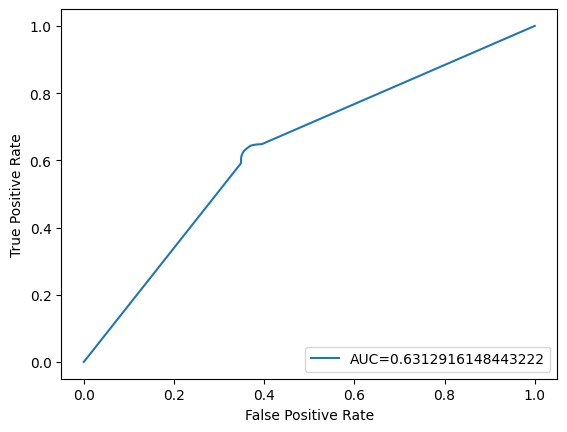

In [ ]:
y_score=dt.predict_proba(x_val_vec)[:,1]
#define metrics
fpr, tpr, _ =roc_curve(y_val,  y_score)
auc = roc_auc_score(y_val, y_score)
#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

From above result: 
It is clear that, The Decision Tree classifier is overfitting.
Need to take countermeasure to reduce the overfitting

In [ ]:
#Utility function to report best scores 
def report (results,n_top=5):
    for i in range(1, n_top+1):
        candidates=np.flatnonzero(results['rank_test_score']==i)
        for candidate in candidates:
            print("Model with rank %d"%i)
            print("Mean validation score: {0:.3f} Std: {1:.3f}".format(results['mean_test_score'][candidate],
                                                                      results['std_test_score'][candidate]))
            print("parameters:{0}".format(results['params'][candidate]))
            print('')

In [ ]:
def get_best_hyperparameter(x_tune_vec,y_tune,clf,random_state=0,cv=2,**param):
  from sklearn.model_selection import RandomizedSearchCV
  import random
  rs=RandomizedSearchCV(clf,param_distributions=param,random_state=random_state,cv=cv)
  rs.fit(x_tune_vec,y_tune)
  report(rs.cv_results_)

In [ ]:
# Best parameter searching for the Decision tree Classifier.
# Best model should have high accuracy,F-1, Precision, and Recall
import scipy
x_tune_vec=x_train_vec[0:150000]
y_tune=y_train[0:150000]
dt=DecisionTreeClassifier()
param_dist = {"max_depth":scipy.stats.randint(2,20),
              "max_features":scipy.stats.randint(1,14),
              "min_samples_leaf":scipy.stats.randint(1,5),
              "criterion": ["gini", "entropy"]}
#clf = RandomizedSearchCV(dt, param_dist, random_state=50,cv=2)
best_params=get_best_hyperparameter(x_tune_vec,y_tune,dt,5,3,**param_dist)

Model with rank 1
Mean validation score: 0.671 Std: 0.002
parameters:{'criterion': 'gini', 'max_depth': 11, 'max_features': 11, 'min_samples_leaf': 2}

Model with rank 2
Mean validation score: 0.671 Std: 0.001
parameters:{'criterion': 'gini', 'max_depth': 11, 'max_features': 9, 'min_samples_leaf': 1}

Model with rank 3
Mean validation score: 0.651 Std: 0.004
parameters:{'criterion': 'entropy', 'max_depth': 13, 'max_features': 2, 'min_samples_leaf': 4}

Model with rank 4
Mean validation score: 0.650 Std: 0.001
parameters:{'criterion': 'entropy', 'max_depth': 16, 'max_features': 7, 'min_samples_leaf': 3}

Model with rank 5
Mean validation score: 0.647 Std: 0.001
parameters:{'criterion': 'gini', 'max_depth': 16, 'max_features': 6, 'min_samples_leaf': 3}



### Selecting the Best Parameter from Random Search CV


In [ ]:
# Training the Model
params={'min_samples_leaf': 2,
 'max_features': 11,
 'max_depth':11,
 'criterion': 'gini'}
dt=DecisionTreeClassifier(random_state=0)
dt=train_decision_tree(x_train_vec,y_train,**params)

In [ ]:
# Training score and validation score
print('Training Accuracy:',dt.score(x_train_vec,y_train))
print('Validation Accuracy:',dt.score(x_val_vec,y_val))

Training Accuracy: 0.7003071428571429
Validation Accuracy: 0.688175


In [ ]:
# Test Score
x=x_test_vec
y=y_test
print('Test Accuracy:',dt.score(x,y))

Test Accuracy: 0.688834375


In [ ]:

y_pred=dt.predict(x)
print(classification_report(y,y_pred))

              precision    recall  f1-score   support

           0       0.69      0.69      0.69    159847
           1       0.69      0.68      0.69    160153

    accuracy                           0.69    320000
   macro avg       0.69      0.69      0.69    320000
weighted avg       0.69      0.69      0.69    320000



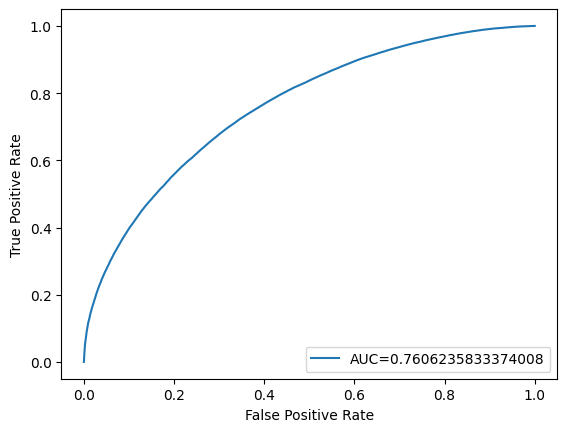

In [ ]:
y_score=dt.predict_proba(x)[:,1]
#define metrics
fpr, tpr, _ =roc_curve(y,  y_score)
auc = roc_auc_score(y, y_score)
#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

### 2.Random Forest Classifier

In [ ]:
# Ensemble Technique:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# Train with Default parameter
rf=RandomForestClassifier()  

In [ ]:
rf.fit(x_train_vec[0:150000],y_train[0:150000])

RandomForestClassifier()

In [ ]:
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [ ]:
print('Training Accuracy:',rf.score(x_train_vec,y_train))
print('Validation Accuracy:',rf.score(x_val_vec,y_val))

Training Accuracy: 0.7461803571428571
Validation Accuracy: 0.70793125


In [ ]:
y_pred=rf.predict(x_train_vec)
print(classification_report(y_train,y_pred))

              precision    recall  f1-score   support

           0       0.74      0.76      0.75    560387
           1       0.75      0.74      0.74    559613

    accuracy                           0.75   1120000
   macro avg       0.75      0.75      0.75   1120000
weighted avg       0.75      0.75      0.75   1120000



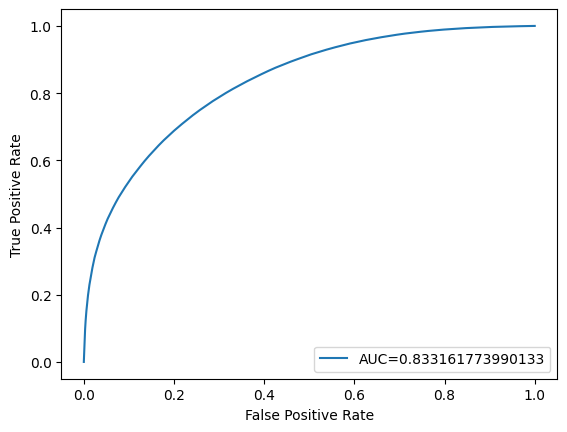

In [ ]:
y_score=rf.predict_proba(x_train_vec)[:,1]
#define metrics
fpr, tpr, _ =roc_curve(y_train,  y_score)
auc = roc_auc_score(y_train, y_score)
#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

In [ ]:
# Let try some other setting:
params={'n_estimators':50,
        'min_samples_leaf': 2,
        'max_features': 11,
        'max_depth':11,
        'criterion': 'gini'}

In [ ]:
rf=RandomForestClassifier()
rf.set_params(**params)
rf.fit(x_train_vec[0:150000],y_train[0:150000])

RandomForestClassifier(max_depth=11, max_features=11, min_samples_leaf=2,
                       n_estimators=50)

In [ ]:
print('Training Accuracy:',rf.score(x_train_vec,y_train))
print('Validation Accuracy:',rf.score(x_val_vec,y_val))

Training Accuracy: 0.7117580357142858
Validation Accuracy: 0.70293125


In [ ]:
print('Test Accuracy:',rf.score(x_test_vec,y_test))

Test Accuracy: 0.7033375


In [ ]:
y_pred=rf.predict(x_test_vec)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.70      0.72      0.71    159847
           1       0.71      0.69      0.70    160153

    accuracy                           0.70    320000
   macro avg       0.70      0.70      0.70    320000
weighted avg       0.70      0.70      0.70    320000



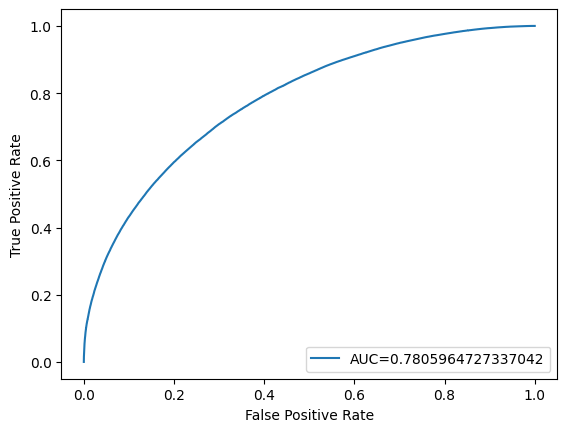

In [ ]:
y_score=rf.predict_proba(x_test_vec)[:,1]
#define metrics
fpr, tpr, _ =roc_curve(y_test,  y_score)
auc = roc_auc_score(y_test, y_score)
#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

### 3. Logistic Regression 

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
lr=LogisticRegression(penalty='l2',max_iter=500,n_jobs=-1)

In [ ]:
lr.fit(x_train_vec,y_train)

LogisticRegression(max_iter=500, n_jobs=-1)

In [ ]:
print('Training Accuracy:',lr.score(x_train_vec,y_train))
print('Validation Accuracy:',lr.score(x_val_vec,y_val))
print('Test Accuracy:',lr.score(x_test_vec,y_test))

Training Accuracy: 0.6946205357142857
Validation Accuracy: 0.69281875
Test Accuracy: 0.694390625


In [ ]:
y_pred=lr.predict(x_test_vec)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.69      0.70      0.70    159847
           1       0.70      0.69      0.69    160153

    accuracy                           0.69    320000
   macro avg       0.69      0.69      0.69    320000
weighted avg       0.69      0.69      0.69    320000



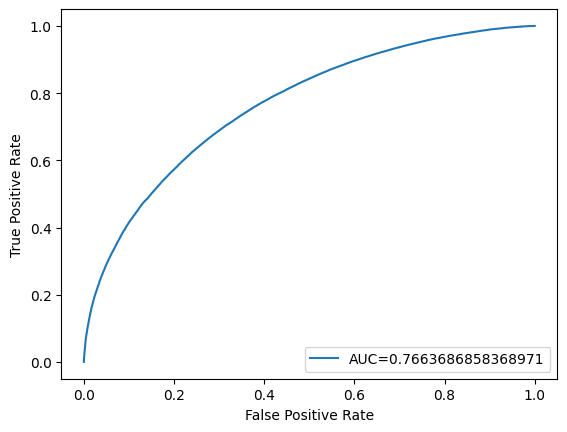

In [ ]:
y_score=lr.predict_proba(x_test_vec)[:,1]
#define metrics
fpr, tpr, _ =roc_curve(y_test,  y_score)
auc = roc_auc_score(y_test, y_score)
#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()